This notebook has been inspired by the book from Sebastian Raschka "Python Machine Learning".

## Multi Layer Perceptron

We are going in this notebook to code a multi layer perceptron from scratch. A multi layer perceptron is a sequence of matrix computation, each followed by a non- linear function. In this notebook we are going to use as non linear function the sigmoid - even if currently ReLu is a more used function. We are going to show how to code a simple neural network.



### Exercise 1 - Define a function that compute the sigmoid and plot the function

The sigmoid is defined as:

$$
\phi(z) = \frac{1}{1+e^{-z}}
$$

In [4]:
import numpy as np

def sigmoid(z):
    ## compute the sigmoid
    return 1 / (1 + np.exp(-z))
z = 0
print(sigmoid(z))

0.5


### Exercise 2 - one hot function

Write a function that takes in input a list of values and returns the one_hot values of them.

In [9]:
import numpy as np

def one_hot(y):
    classes = sorted(set(y))  # Ensure consistent ordering
    class_to_index = {cls: idx for idx, cls in enumerate(classes)}
    one_hot_encoded = np.zeros((len(y), len(classes)))

    for i, val in enumerate(y):
        one_hot_encoded[i][class_to_index[val]] = 1

    return one_hot_encoded


In [10]:
assert (one_hot([1,2]) == np.array([[1,0], [0., 1]]) ).all()
assert (one_hot([2,1]) == np.array([[0,1], [1., 0]]) ).all()
assert (one_hot([2, 1,2,3,1, 4]) == np.array([[0.,1.,0.,0.], [1,0.,0.,0.], [0.,1.,0., 0], [0, 0, 1, 0], [1.,0.,0.,0.], [0., 0., 0., 1.]])).all()

### Exercise 3 - Cost function - logistic cost function

We are going to use as cost function the logistic cost function (with no regularization). We are also going to normalize the logistic cost functionwith respect to the number of values we are considering, to be able to evaluate it on datasets of different lenghts.

$$
C =-\frac{1}{n} \sum_{1}^{n}{ \bigg( y^{i}*\log(f(x^{i}))+(1-y^{i}) *\log(1-f(x^{i})) \bigg)}
$$

where

- n isthe number of datapoints
- $y^{i}$ is the label for the $i^{th}$ element
- $f$ is the prediction function
- $x^{i}$ is the $i^{th}$ element of the dataset


In [13]:
import numpy as np

def cost_function(y_label, prediction):
    epsilon = 1e-12  # to avoid log(0)
    prediction = np.clip(prediction, epsilon, 1 - epsilon)
    n = y_label.shape[0]
    cost = - (1 / n) * np.sum(
        y_label * np.log(prediction) + (1 - y_label) * np.log(1 - prediction)
    )
    return cost



In [14]:
assert np.abs(cost_function(np.array([[1,0]]), np.array([[0.9,0.1]])) - 0.21072103131565256) < 0.000001
assert np.abs(cost_function(np.array([[1,0,], [0, 1]]), np.array([[0.999,0.1], [0.5, 0.5]])) - 0.7463276885556502) < 0.000001

###  Exercise 4 - Forward propagation

In the following we are going to consider a multi-layer perceptron having only one hidden layer of a certain size. The non-linear function is going to be the sigmoid.

Let X be data. The algorithm to compute the forward pass is the following:



$$z_{h} = X*w_{h} + b_{h} $$
$$a_{h} = \phi(z_{h})$$
$$z_{out} = a_{h}*w_{out} + b_{out}$$
$$a_{out} = \phi(z_{out})$$

Function should return values for $z_{h}, a_{h}, z_{out}, a_{out}$.

In [15]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def forward(X, w_h, b_h, w_out, b_out):
    X = np.array(X)
    w_h = np.array(w_h)
    b_h = np.array(b_h)
    w_out = np.array(w_out)
    b_out = np.array(b_out)

    z_h = np.dot(X, w_h) + b_h       # (1, 3) · (3, 2) = (1, 2)
    a_h = sigmoid(z_h)               # apply sigmoid
    z_out = np.dot(a_h, w_out) + b_out  # (1, 2) · (2, 3) = (1, 3)
    a_out = sigmoid(z_out)           # final activation

    return z_h, a_h, z_out, a_out


In [16]:
forward_X_test = [[1,0,1]]
forward_wh_test = [[0,1], [1,0], [1,1]]
forward_bh_test = [1,1]
forward_wout_test = [[1,4,5], [2,-1, -1]]
forward_bout_test = [1,2,-1]

t1, t2, t3, t4 = forward(forward_X_test, forward_wh_test,forward_bh_test, forward_wout_test, forward_bout_test)

assert (t1 == np.array([[2,3]])).all()
assert (t2 - np.array([[0.88079708, 0.95257413]]) < 0.00001).all()
assert (t3 - np.array([[3.78594533 ,4.57061419, 2.45141126]]) < 0.000001).all()
assert (t4 - np.array([[0.99987661, 0.99908895, 0.99752738]]) < 0.00001).all()

### Exercise 5 - Back propagation

We are going to need before being able to train a neural network, the back propagation step. In this step we are going to compute the error the model is doing with respect to the true label and backpropagate this information to every layer. Then we will update the weight of each layer with the information from the gradient.

We are going to compute:


$$\delta_{out} = a_{out} - y$$
$$\frac{\partial \phi(z_{h})}{\partial z_{h}} = a_{h}*(1-a_{h})$$
$$\delta_{h} = (\delta_{out} w_{out}^{T})*(a_{h}*(1-a_{h}))$$
$$\nabla(w_{h}) = X^{T} \delta_{h}$$
$$\nabla(b_{h}) = \sum{\delta_{h}}$$
$$\nabla(w_{out}) = a_{h}^{T}\delta_{out}$$
$$\nabla(b_{out}) = \sum{\delta_{out}}$$


It should return the values of


$$\nabla(w_{h})$$
$$\nabla(b_{h})$$
$$\nabla(w_{out})$$
$$\nabla(b_{out})$$


In [17]:
import numpy as np

def sigmoid_derivative(a):
    return a * (1 - a)

def backpropagation(X, y, z_h, a_h, z_out, a_out, w_out):
    X = np.array(X)
    y = np.array([y])  # Make sure y is shape (1, 3)
    a_out = np.array(a_out)
    a_h = np.array(a_h)
    w_out = np.array(w_out)

    # Step 1: Output error
    delta_out = a_out - y

    # Step 2: Hidden layer derivative
    dphi_h = sigmoid_derivative(a_h)

    # Step 3: Hidden layer error
    delta_h = np.dot(delta_out, w_out.T) * dphi_h

    # Step 4: Gradients
    grad_wh = np.dot(X.T, delta_h)
    grad_bh = np.sum(delta_h, axis=0)
    grad_wout = np.dot(a_h.T, delta_out)
    grad_bout = np.sum(delta_out, axis=0)

    return grad_wh, grad_bh, grad_wout, grad_bout




In [18]:
g1, g2, g3, g4 = backpropagation(np.array(forward_X_test), [0,1,0], t1, t2, t3, t4, np.array(forward_wout_test))


assert np.abs((g1 - np.array([[0.58168091, 0.04721922],
 [0.  ,       0.        ],
 [0.58168091, 0.04721922]]))).sum() < 0.0001
assert np.abs((g2 - np.array([0.58168091, 0.04721922]))).sum() < 0.0001
assert np.abs((g3 - np.array([[ 0.86125738, -0.00902424,  0.81091868],
 [ 0.93144212, -0.00975964,  0.87700127]]))).sum() < 0.0001
assert np.abs((g4 - np.array([ 0.97781589, -0.01024554,  0.92066459]))).sum() < 0.0001


### Exercice 6 - Putting all together

We are going to create a class called MultiLayerPerceptron that takes as input in the init:

- the number of features of the dataset $n_{features}$
- the number of hidden neurons $n_{hidden}$
- the number of output neurons $n_{output}$ (number of unique labels in target)

We are going to initiate as class variables:
- bias vector $b_{h}$ as a set of zeros of length $n_{hidden}$
- matrix $w_{h}$ as a random normal matrix with size $(n_{features}, n_{hidden})$
- bias vector $b_{out}$ as a set of zeros of length $n_{output}$
- matrix $w_{out}$ as a random normal matrix with size $(n_{hidden}, n_{output})$

Then we will integrate the two functions forward and backprop by using the class variables instead of having a static function. We are going to use both in the train method

In [19]:
import numpy as np
import random

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(a):
    return a * (1 - a)

def cost_function(y_label, prediction):
    epsilon = 1e-12
    prediction = np.clip(prediction, epsilon, 1 - epsilon)
    n = y_label.shape[0]
    return - (1 / n) * np.sum(
        y_label * np.log(prediction) + (1 - y_label) * np.log(1 - prediction)
    )

class MultiLayerPerceptron:
    def __init__(self, n_features, n_hidden, n_output):
        self.w_h = np.random.randn(n_features, n_hidden)
        self.b_h = np.zeros(n_hidden)
        self.w_out = np.random.randn(n_hidden, n_output)
        self.b_out = np.zeros(n_output)

    def forward(self, X):
        z_h = np.dot(X, self.w_h) + self.b_h
        a_h = sigmoid(z_h)
        z_out = np.dot(a_h, self.w_out) + self.b_out
        a_out = sigmoid(z_out)
        return z_h, a_h, z_out, a_out

    def backprop(self, X_batch, y_batch, z_h, a_h, z_out, a_out):
        delta_out = a_out - y_batch
        delta_h = np.dot(delta_out, self.w_out.T) * sigmoid_derivative(a_h)
        grad_w_h = np.dot(X_batch.T, delta_h)
        grad_b_h = np.sum(delta_h, axis=0)
        grad_w_out = np.dot(a_h.T, delta_out)
        grad_b_out = np.sum(delta_out, axis=0)
        return grad_w_h, grad_b_h, grad_w_out, grad_b_out

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate):
        epoch_loss_train = []
        epoch_loss_val = []
        batch_loss = []

        for idx_epoch in range(epochs):
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
                batch_idx = indices[start_idx:start_idx + batch_size]
                X_batch = X_train[batch_idx]
                y_batch = y_train[batch_idx]

                # Forward pass
                z_h, a_h, z_out, a_out = self.forward(X_batch)
                batch_cost = cost_function(y_batch, a_out)
                batch_loss.append(batch_cost)

                # Backpropagation
                grad_w_h, grad_b_h, grad_w_out, grad_b_out = self.backprop(
                    X_batch, y_batch, z_h, a_h, z_out, a_out)

                # Gradient descent update
                self.w_h -= learning_rate * grad_w_h
                self.b_h -= learning_rate * grad_b_h
                self.w_out -= learning_rate * grad_w_out
                self.b_out -= learning_rate * grad_b_out

            # After full epoch
            _, _, _, a_out_train = self.forward(X_train)
            cost_train = cost_function(y_train, a_out_train)
            _, _, _, a_out_val = self.forward(X_val)
            cost_val = cost_function(y_val, a_out_val)

            epoch_loss_train.append(cost_train)
            epoch_loss_val.append(cost_val)

            print(f'Epoch {idx_epoch}: train {cost_train:.4f} - eval {cost_val:.4f}')

        return epoch_loss_train, epoch_loss_val, batch_loss

    def predict(self, X):
        _, _, _, prediction = self.forward(X)
        return np.argmax(prediction, axis=1)

    def predict_proba(self, X):
        _, _, _, prediction = self.forward(X)
        return prediction


### Import the datasets

We are going to use the digits dataset from sklearn. We will build a train, validation and test set.

In [20]:
from sklearn.datasets import load_digits

In [21]:
digits = load_digits()

In [22]:
X = digits.data
y = one_hot(digits.target)

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)

### Exercice 7 - training a classifier

Create a new object nn with the correct dimension for values $n_{features}$ and $n_{output}$. You can choose the number of hidden neurons you want to use.

Call the *train* method with different epochs, batch_size and learning_rate.

In [25]:
n_features = X.shape[1]      # 64 pixels per digit
n_output = y.shape[1]        # 10 classes (digits 0–9)
n_hidden = 32                # You can tweak this!

nn = MultiLayerPerceptron(n_features, n_hidden, n_output) #instance class


In [26]:
epochs = 50
batch_size = 32
learning_rate = 0.1

epoch_loss_train, epoch_loss_val, batch_loss = nn.train(
    X_train, y_train,
    X_val, y_val,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate
)


<ipython-input-19-99387d93e373>:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 0: train 8.9618 - eval 9.5161
Epoch 1: train 4.1595 - eval 4.0495
Epoch 2: train 6.7817 - eval 6.3144
Epoch 3: train 5.8369 - eval 6.2468
Epoch 4: train 4.5526 - eval 4.4708
Epoch 5: train 5.0703 - eval 4.6979
Epoch 6: train 6.2333 - eval 5.7375
Epoch 7: train 6.4977 - eval 6.1039
Epoch 8: train 4.5019 - eval 4.4202
Epoch 9: train 4.5572 - eval 4.4080
Epoch 10: train 4.4916 - eval 4.2461
Epoch 11: train 4.8022 - eval 4.6369
Epoch 12: train 5.6663 - eval 5.4594
Epoch 13: train 4.8859 - eval 5.2748
Epoch 14: train 6.4087 - eval 6.7943
Epoch 15: train 3.8709 - eval 4.1220
Epoch 16: train 6.1043 - eval 6.6630
Epoch 17: train 5.1539 - eval 5.7133
Epoch 18: train 7.1359 - eval 7.0810
Epoch 19: train 6.8848 - eval 6.8128
Epoch 20: train 4.2290 - eval 4.5526
Epoch 21: train 5.6985 - eval 5.7033
Epoch 22: train 5.7238 - eval 5.9349
Epoch 23: train 3.3213 - eval 3.5060
Epoch 24: train 4.7471 - eval 5.2002
Epoch 25: train 2.6964 - eval 2.8841
Epoch 26: train 4.6057 - eval 4.7480
Epoch 27: t

### Exercice 8 - compute accuracy metrics for train, test and valuation

In [27]:
from sklearn.metrics import accuracy_score

# Predict on all sets
y_pred_train = nn.predict(X_train)
y_pred_val = nn.predict(X_val)
y_pred_test = nn.predict(X_test)

# Get actual labels from one-hot
y_true_train = np.argmax(y_train, axis=1)
y_true_val = np.argmax(y_val, axis=1)
y_true_test = np.argmax(y_test, axis=1)

# Compute accuracies
acc_train = accuracy_score(y_true_train, y_pred_train)
acc_val = accuracy_score(y_true_val, y_pred_val)
acc_test = accuracy_score(y_true_test, y_pred_test)

# Print results
print(f"📚 Train Accuracy:      {acc_train:.4f}")
print(f"🧪 Validation Accuracy: {acc_val:.4f}")
print(f"🧠 Test Accuracy:       {acc_test:.4f}")


📚 Train Accuracy:      0.2620
🧪 Validation Accuracy: 0.2840
🧠 Test Accuracy:       0.3222


<ipython-input-19-99387d93e373>:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [33]:
from sklearn.metrics import accuracy_score

def evaluate_accuracy(nn, X, y_onehot):
    y_pred = nn.predict(X)
    y_true = np.argmax(y_onehot, axis=1)
    return accuracy_score(y_true, y_pred)

# Usage:
evaluate_accuracy(nn, X_train, y_train)



<ipython-input-19-99387d93e373>:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0.26200873362445415

### Exercice 9 - show examples of mislabelled images for training, valuation and test sets

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

# Utility function to show mislabelled digits
def show_mislabelled(X, y_true_onehot, y_pred, title, max_images=5):
    y_true = np.argmax(y_true_onehot, axis=1)
    misclassified_indices = np.where(y_pred != y_true)[0]

    print(f"{title} – {len(misclassified_indices)} mislabelled out of {len(y_true)} samples.")

    plt.figure(figsize=(12, 2.5))
    for i, idx in enumerate(misclassified_indices[:max_images]):
        image = X[idx].reshape(8, 8)  # digits dataset has 8x8 images
        true_label = y_true[idx]
        pred_label = y_pred[idx]

        plt.subplot(1, max_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')

    plt.suptitle(title)
    plt.show()



<ipython-input-19-99387d93e373>:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Training Set – 1014 mislabelled out of 1374 samples.


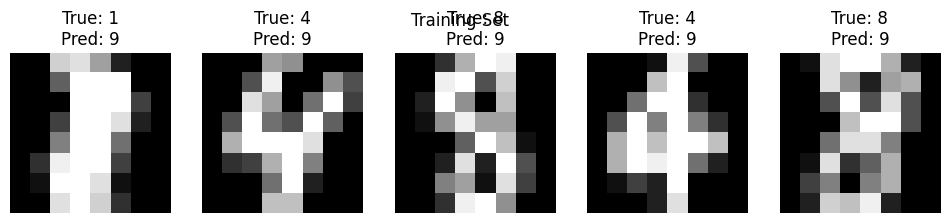

Validation Set – 174 mislabelled out of 243 samples.


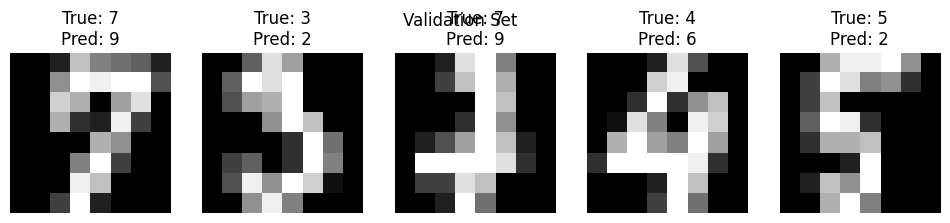

Test Set – 122 mislabelled out of 180 samples.


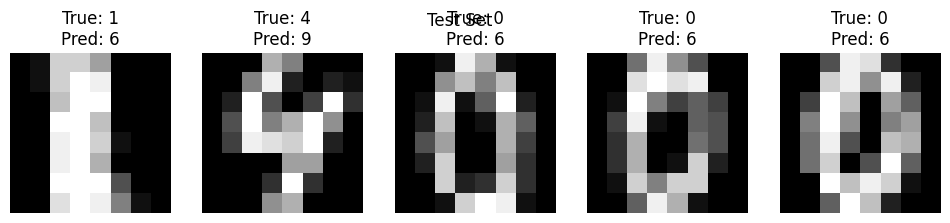

In [36]:
# Generate predictions
y_pred_train = nn.predict(X_train)
y_pred_val = nn.predict(X_val)
y_pred_test = nn.predict(X_test)

# Show mislabelled images
show_mislabelled(X_train, y_train, y_pred_train, "Training Set")
show_mislabelled(X_val, y_val, y_pred_val, "Validation Set")
show_mislabelled(X_test, y_test, y_pred_test, "Test Set")


### Exercice 9 - plot training graphs

Plot a graph having epoch loss for train and validation sets.

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_training_graph(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Training Loss", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


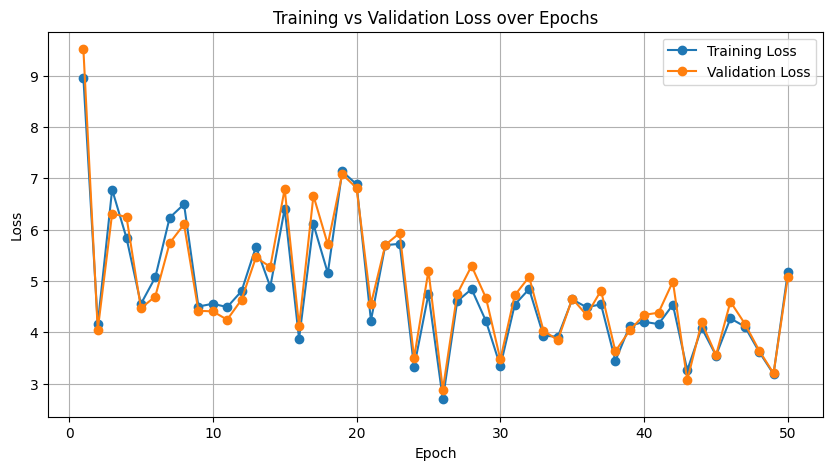

In [38]:
plot_training_graph(epoch_loss_train, epoch_loss_val)


Add to the plot a graph having epoch loss for batch loss.

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_training_graph(epoch_train_loss, epoch_val_loss, batch_loss):
    epochs = range(1, len(epoch_train_loss) + 1)
    batches = range(1, len(batch_loss) + 1)

    plt.figure(figsize=(12, 6))

    # Plot epoch-level loss
    plt.plot(epochs, epoch_train_loss, label="Training Loss (epoch)", marker='o', linewidth=2)
    plt.plot(epochs, epoch_val_loss, label="Validation Loss (epoch)", marker='o', linewidth=2)

    # Plot batch-level loss
    plt.plot(batches, batch_loss, label="Training Loss (batch)", linestyle='--', alpha=0.5)

    plt.xlabel("Epochs / Batches")
    plt.ylabel("Loss")
    plt.title("Loss during Training — Epoch vs Batch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


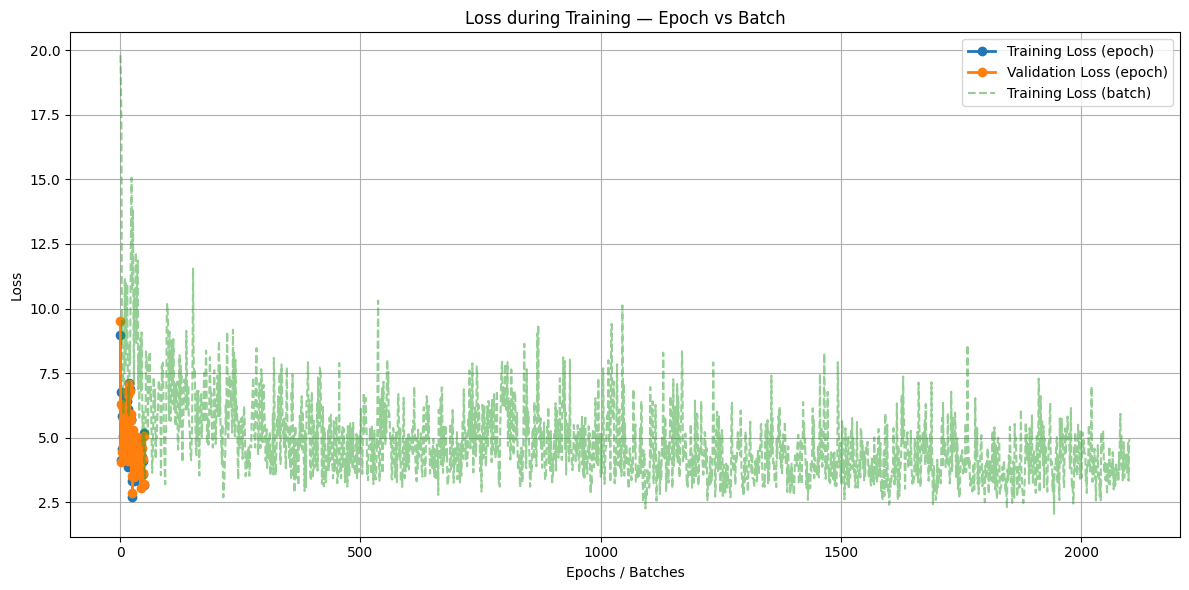

In [40]:
plot_training_graph(epoch_loss_train, epoch_loss_val, batch_loss)


# Using pytorch

By using pytorch documentation, replicate what has been done from scratch.

Change the definition of the network to see what works better.

In [41]:
import torch
from torch import nn

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(64, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 10)
        )

    def forward(self, x):
        logits = self.model(x)
        return logits

    def train_model(self, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate):
        epoch_loss_train = []
        epoch_loss_val = []
        batch_loss = []

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        for idx_epoch in range(epochs):
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
                batch_idx = indices[start_idx:start_idx + batch_size]

                optimizer.zero_grad()

                X_batch = torch.from_numpy(X_train[batch_idx]).float()
                y_batch = torch.from_numpy(np.argmax(y_train[batch_idx], axis=1)).long()

                outputs = self.forward(X_batch)
                loss = criterion(outputs, y_batch)

                loss.backward()
                optimizer.step()

                batch_loss.append(loss.item())

            # Compute train and validation loss
            with torch.no_grad():
                pred_train = self.forward(torch.from_numpy(X_train).float())
                loss_train = criterion(pred_train, torch.from_numpy(np.argmax(y_train, axis=1)).long())

                pred_val = self.forward(torch.from_numpy(X_val).float())
                loss_val = criterion(pred_val, torch.from_numpy(np.argmax(y_val, axis=1)).long())

            print(f'Epoch {idx_epoch+1}: Train Loss = {loss_train.item():.4f}, Val Loss = {loss_val.item():.4f}')

            epoch_loss_train.append(loss_train.item())
            epoch_loss_val.append(loss_val.item())

        return epoch_loss_train, epoch_loss_val, batch_loss

    def compute_accuracy(self, X_values, y_values):
        with torch.no_grad():
            X_tensor = torch.from_numpy(X_values).float()
            y_tensor = torch.from_numpy(np.argmax(y_values, axis=1)).long()
            outputs = self.forward(X_tensor)
            preds = torch.argmax(outputs, dim=1)
            correct = (preds == y_tensor).sum().item()
            total = y_tensor.size(0)
            accuracy = correct / total
        return accuracy


In [43]:
torch_nn = NeuralNetwork()

In [45]:
epochs = 50
batch_size = 32
learning_rate = 0.01

epoch_loss_train, epoch_loss_val, batch_loss = torch_nn.train_model(
    X_train, y_train,
    X_val, y_val,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate
)

print("Train Accuracy:", torch_nn.compute_accuracy(X_train, y_train))
print("Val Accuracy:", torch_nn.compute_accuracy(X_val, y_val))
print("Test Accuracy:", torch_nn.compute_accuracy(X_test, y_test))


Epoch 1: Train Loss = 0.8546, Val Loss = 0.9158
Epoch 2: Train Loss = 0.4698, Val Loss = 0.4707
Epoch 3: Train Loss = 0.2370, Val Loss = 0.2809
Epoch 4: Train Loss = 0.1899, Val Loss = 0.2309
Epoch 5: Train Loss = 0.1118, Val Loss = 0.1726
Epoch 6: Train Loss = 0.1613, Val Loss = 0.2658
Epoch 7: Train Loss = 0.1725, Val Loss = 0.2727
Epoch 8: Train Loss = 0.1959, Val Loss = 0.2771
Epoch 9: Train Loss = 0.0658, Val Loss = 0.1899
Epoch 10: Train Loss = 0.2217, Val Loss = 0.3897
Epoch 11: Train Loss = 0.1543, Val Loss = 0.2577
Epoch 12: Train Loss = 0.0582, Val Loss = 0.1909
Epoch 13: Train Loss = 0.0595, Val Loss = 0.1986
Epoch 14: Train Loss = 0.0974, Val Loss = 0.2228
Epoch 15: Train Loss = 0.0245, Val Loss = 0.1556
Epoch 16: Train Loss = 0.0417, Val Loss = 0.1830
Epoch 17: Train Loss = 0.2016, Val Loss = 0.3902
Epoch 18: Train Loss = 0.1652, Val Loss = 0.3545
Epoch 19: Train Loss = 0.2097, Val Loss = 0.3506
Epoch 20: Train Loss = 0.0584, Val Loss = 0.2636
Epoch 21: Train Loss = 0.0423

### Exercice 10

Evaluate the accuracy for train, evaluation and test set. Add a method compute_accuracy to the class NeuralNetwork

In [46]:
def compute_accuracy(self, X_values, y_values):
    self.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        X_tensor = torch.from_numpy(X_values).float()
        y_tensor = torch.from_numpy(np.argmax(y_values, axis=1)).long()

        outputs = self.forward(X_tensor)
        predictions = torch.argmax(outputs, dim=1)

        correct = (predictions == y_tensor).sum().item()
        total = y_tensor.size(0)
        accuracy = correct / total
    self.train()  # Switch back to training mode if needed
    return accuracy


In [48]:
train_acc = torch_nn.compute_accuracy(X_train, y_train)
val_acc = torch_nn.compute_accuracy(X_val, y_val)
test_acc = torch_nn.compute_accuracy(X_test, y_test)

print(f"📚 Train Accuracy:     {train_acc:.4f}")
print(f"🧪 Validation Accuracy: {val_acc:.4f}")
print(f"🧠 Test Accuracy:       {test_acc:.4f}")


📚 Train Accuracy:     1.0000
🧪 Validation Accuracy: 0.9794
🧠 Test Accuracy:       0.9667


### Exercice 11

Plot the graphs of training for both training and evaluation set.

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Training Loss", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


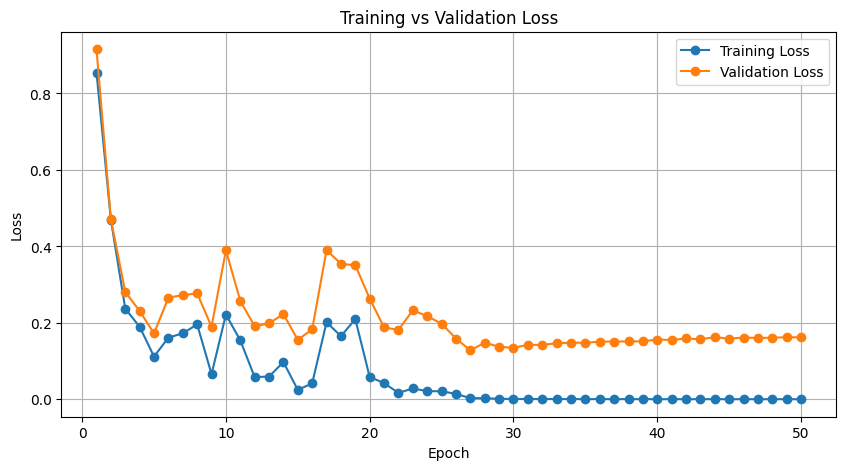

In [50]:
plot_loss_curves(epoch_loss_train, epoch_loss_val)


### Exercice 12

Find the set of images that are wrongly classified by both models.

In [58]:
nn = MultiLayerPerceptron(n_features, n_hidden, n_output)

TypeError: MultiLayerPerceptron() takes no arguments

In [57]:
# True labels
y_true_test = np.argmax(y_test, axis=1)

# NumPy MLP predictions
y_pred_mlp = mlp.predict(X_test)  # ✅ use your actual model variable here

# PyTorch predictions
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test).float()
    outputs = torch_nn(X_test_tensor)
    y_pred_torch = torch.argmax(outputs, dim=1).numpy()




NameError: name 'mlp' is not defined

### Exercice 13 - Use a convolutional neuronal network instead of a linear network (optional)

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # (8x8) → (8x8)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # (8x8) → (8x8)
        self.pool = nn.MaxPool2d(2, 2)  # (8x8) → (4x4)
        self.fc1 = nn.Linear(32 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))      # (1, 8, 8) → (16, 8, 8)
        x = self.pool(F.relu(self.conv2(x)))  # (16, 8, 8) → (32, 4, 4)
        x = x.view(-1, 32 * 4 * 4)     # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # (8x8) → (8x8)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # (8x8) → (8x8)
        self.pool = nn.MaxPool2d(2, 2)  # (8x8) → (4x4)
        self.fc1 = nn.Linear(32 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))      # (1, 8, 8) → (16, 8, 8)
        x = self.pool(F.relu(self.conv2(x)))  # (16, 8, 8) → (32, 4, 4)
        x = x.view(-1, 32 * 4 * 4)     # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [61]:
# Reshape and convert to torch tensors
X_train_cnn = torch.tensor(X_train.reshape(-1, 1, 8, 8)).float()
X_val_cnn = torch.tensor(X_val.reshape(-1, 1, 8, 8)).float()
X_test_cnn = torch.tensor(X_test.reshape(-1, 1, 8, 8)).float()

y_train_cnn = torch.tensor(np.argmax(y_train, axis=1)).long()
y_val_cnn = torch.tensor(np.argmax(y_val, axis=1)).long()
y_test_cnn = torch.tensor(np.argmax(y_test, axis=1)).long()


In [63]:
model = CNNClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 10
batch_size = 32

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_cnn.size(0))

    for i in range(0, X_train_cnn.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x = X_train_cnn[indices]
        batch_y = y_train_cnn[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_cnn)
        val_loss = criterion(val_outputs, y_val_cnn)
        val_preds = torch.argmax(val_outputs, dim=1)
        acc = (val_preds == y_val_cnn).float().mean().item()

    print(f"Epoch {epoch+1}: Val Loss = {val_loss.item():.4f}, Val Acc = {acc:.4f}")


Epoch 1: Val Loss = 0.2741, Val Acc = 0.9383
Epoch 2: Val Loss = 0.1110, Val Acc = 0.9588
Epoch 3: Val Loss = 0.0649, Val Acc = 0.9877
Epoch 4: Val Loss = 0.0580, Val Acc = 0.9877
Epoch 5: Val Loss = 0.0479, Val Acc = 0.9918
Epoch 6: Val Loss = 0.0517, Val Acc = 0.9918
Epoch 7: Val Loss = 0.0480, Val Acc = 0.9959
Epoch 8: Val Loss = 0.0541, Val Acc = 0.9918
Epoch 9: Val Loss = 0.0538, Val Acc = 0.9794
Epoch 10: Val Loss = 0.0412, Val Acc = 0.9959


In [64]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_cnn)
    test_preds = torch.argmax(test_outputs, dim=1)
    test_acc = (test_preds == y_test_cnn).float().mean().item()
    print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9722
